In [226]:
%pip install pandas numpy scikit-learn ucimlrepo lime

Note: you may need to restart the kernel to use updated packages.


In [234]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo 
import lime
from lime import lime_tabular

import pickle as pkl

from bayes_opt import BayesianOptimization
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.stats import uniform
from scipy.special import softmax
import shap

MODEL_NAME = 'Wine'

MODEL_FUNCTION = DecisionTreeClassifier
model_params = {}
coding = {"Wine": 109}


In [228]:
# fetch dataset 
split_size = 0.3
seed = 1234567

dataset_id = coding[MODEL_NAME]

wine = fetch_ucirepo(id=109) 

In [229]:
# data (as pandas dataframes) 
X = wine.data.features
y = wine.data.targets.to_numpy()
y = y.reshape((len(y), ))
    

n_classes = len(np.unique(y))
n_feats = X.shape[1]
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = split_size, random_state = seed)

normalizer = Normalizer().fit(x_train)
encoder = LabelEncoder().fit(y_train)

x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)
y_train = encoder.transform(y_train)
y_test  = encoder.transform(y_test)

In [230]:
def evaluate_model(model, samples, targets):
    pred = model.predict(samples)
    return accuracy_score(targets, pred)

In [242]:
model = MODEL_FUNCTION(*model_params)
model.fit(x_train, y_train)

acc_train = evaluate_model(model, x_train, y_train)
acc_test  = evaluate_model(model, x_test, y_test)

print(acc_train, acc_test)

1.0 1.0


In [173]:
with open(f'{MODEL_NAME}.pkl', 'wb') as f:
    pkl.dump(model, f)

In [174]:
predicted_labels = model.predict(x_test)

### Interpretability

In [175]:
def get_local_interpretation(explainer, predict_function, sample, num_features):
    
    exp = explainer.explain_instance(sample, predict_function, num_features = len(sample))
    local_exp = list(exp.local_exp.values())[0]
    local_exp = sorted(local_exp)
    
    explanations = [x[1] for x in local_exp]
    return explanations

In [207]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data = x_train,
    mode = 'classification'
)

def get_optimal_gmm(n_components):
    c = round(n_components)
    gmm = GaussianMixture(n_components = c).fit(x_train)
    return gmm.bic(x_train)

parameters = {'n_components': (0, len(x_train)//4)}

gmm = GaussianMixture(n_components= n_classes).fit(x_train)
gbm_bo = BayesianOptimization(get_optimal_gmm, parameters, random_state=111, allow_duplicate_points=True)
gbm_bo.maximize(init_points = 30, n_iter = 10)

|   iter    |  target   | n_comp... |
-------------------------------------
| 1         | -7.5e+03  | 18.98     |
| 2         | -1.403e+0 | 5.241     |
| 3         | -9.883e+0 | 13.52     |
| 4         | -5.156e+0 | 23.85     |
| 5         | -1.223e+0 | 9.155     |
| 6         | -1.403e+0 | 4.624     |
| 7         | -1.534e+0 | 0.6968    |
| 8         | -1.037e+0 | 13.03     |
| 9         | -1.315e+0 | 7.399     |
| 10        | -1.172e+0 | 10.47     |
| 11        | -1.743e+0 | 30.71     |
| 12        | -1.312e+0 | 7.37      |
| 13        | -1.489e+0 | 2.517     |
| 14        | -6.584e+0 | 20.76     |
| 15        | -7.517e+0 | 19.26     |
| 16        | -1.221e+0 | 8.502     |
| 17        | -9.903e+0 | 14.45     |
| 18        | -1.447e+0 | 3.669     |
| 19        | -1.52e+04 | 2.293     |
| 20        | -3.225e+0 | 27.92     |
| 21        | -4.669e+0 | 24.61     |
| 22        | -4.173e+0 | 26.06     |
| 23        | -4.677e+0 | 25.27     |
| 24        | -1.725e+0 | 30.72     |
| 25        

In [208]:
def get_scores(ex):
    '''Function to normalize scores using a softmax function multiplied by correlation signs'''
    signs = np.sign(ex)
    abs_softmax = softmax(np.abs(ex))
    return abs_softmax*signs

In [216]:
def run_explainability(fit_dist, train_samples, model, explainer, main_dist, num_samples, mcmc = False):
    if mcmc == True:
        # run monte carlo trials
        samples, gmm_class = fit_dist.sample(num_samples)       # generate samples from the fit gmm
        explanations = []                                       # list to store explanations
        for sample in tqdm(samples):
            interpret = get_local_interpretation(explainer, model.predict_proba, sample, n_feats)
            sigmoid_interpretation = get_scores(interpret)
            explanations.append(sigmoid_interpretation)
            
        agg_explanations = np.mean(np.array(explanations), axis = 0)        # aggregating
        
        return agg_explanations, explanations
    

    else:
        # importance sampling
        for i in train_samples:
            
    
        
        
def rank_explanations(explanations):
    return sorted(list(zip(range(len(explanations)), explanations)), key = lambda x: -abs(x[1]))

In [210]:
aggregated, point_explanations = run_explainability(gmm, x_train, model, explainer, None, 1000, mcmc = True)

100%|██████████| 1000/1000 [00:15<00:00, 66.15it/s]


In [217]:
rank_explanations(aggregated)

[(3, 0.04617325244566326),
 (9, -0.03993967782324904),
 (10, 0.010348201772541496),
 (1, -0.005890853870338956),
 (4, -0.005867917618491432),
 (8, -0.0038131525180631646),
 (12, -0.0037540797648841122),
 (7, -0.001798897017011831),
 (2, -0.0017271300056940085),
 (6, -0.0013279739245751713),
 (11, -0.000791438543467537),
 (5, -0.0002891283140941929),
 (0, -0.0002557544337576667)]

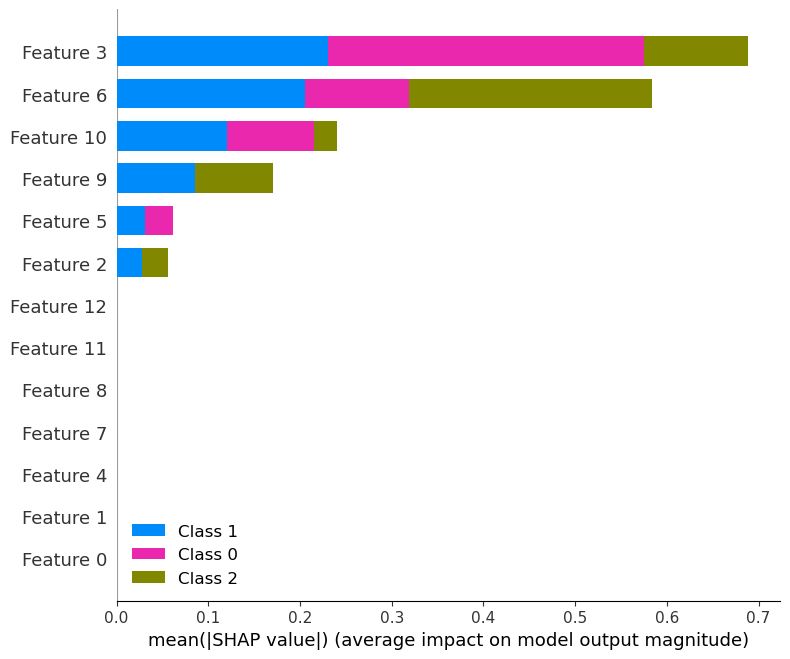

In [297]:
se = shap.Explainer(model)
shap_values = se.shap_values(x_train)

# def mean_shap_value(shap_vals):
#     for i in shap_values:
        
        
shap.summary_plot(shap_values)

## Testing

### Local2Global

In [261]:
vals = list(set(np.arange(n_feats)).difference(set([3,9,10,11])))
model_l2g = MODEL_FUNCTION(*model_params)
model_l2g.fit(x_train[:, vals], y_train)

acc_train_l2g = evaluate_model(model_l2g, x_train[:, vals], y_train)
acc_test_l2g  = evaluate_model(model_l2g, x_test[:, vals], y_test)

print(acc_train_l2g, acc_test_l2g)

1.0 0.8703703703703703


### Shap

In [249]:
# shap features are 3, 6, 10, 9
vals = list(set(np.arange(n_feats)).difference(set([3,6,10,9])))

# x_train

In [275]:
model_shap = MODEL_FUNCTION(*model_params)
model_shap.fit(x_train[:, vals], y_train)

acc_train_shap = evaluate_model(model_shap, x_train[:, vals], y_train)
acc_test_shap  = evaluate_model(model_shap, x_test[:, vals], y_test)

print(acc_train_shap, acc_test_shap)

1.0 0.8703703703703703
